### Notebook 1: ARIMAX Model for Coinbase (COIN)

# ARIMAX Model for Predicting Coinbase Stock Prices (COIN)

## Overview
This notebook presents the implementation and evaluation of the ARIMAX (AutoRegressive Integrated Moving Average with Exogenous Variables) model for predicting the stock prices of Coinbase (COIN). The ARIMAX model leverages both the intrinsic patterns in the time series data and the impact of external factors.

## Objectives
- **Feature Engineering:** Develop relevant features from raw financial and economic data for COIN.
- **Model Implementation:** Implement the ARIMAX model to predict COIN stock prices.
- **Model Evaluation:** Evaluate the performance of the ARIMAX model using MSE, RMSE, MAE, and R2 scores.
- **Insights and Interpretation:** Provide insights into the model's performance and the impact of various features on COIN stock prices.

## Data Sources
- **Financial Data:** Historical prices for Coinbase stock from Yahoo Finance.
- **Economic Data:** Key economic indicators from the Federal Reserve Economic Data (FRED), including Real Disposable Income, Fed Funds Rate, and more.

## Methodology
1. **Data Collection:** Download and preprocess COIN financial and economic data.
2. **Feature Engineering:** Create technical indicators and integrate economic indicators relevant to COIN.
3. **Model Development:** Build and train the ARIMAX model for COIN stock prices.
4. **Model Evaluation:** Assess the model's performance using key metrics.
5. **Insights and Interpretation:** Analyze the results to understand the model's predictions and market behavior for COIN.

## Evaluation Metrics
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **Mean Absolute Error (MAE)**
- **R2 Score**

## Key Findings
- **Training and Test Metrics:** Evaluate the model's performance on training and test data.
- **Feature Impact:** Understand the influence of various features on the predictions.

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Testing (0, 0, 0) x (0, 0, 0, 12) - R2: 0.7362751546102126
Testing (0, 0, 0) x (0, 0, 1, 12) - R2: 0.7319112647672733
Testing (0, 0, 0) x (0, 1, 0, 12) - R2: 0.4406197036228406
Testing (0, 0, 0) x (0, 1, 1, 12) - R2: 0.7132342288058817
Testing (0, 0, 0) x (1, 0, 0, 12) - R2: 0.7331287591446818
Testing (0, 0, 0) x (1, 0, 1, 12) - R2: 0.7320048286206278
Testing (0, 0, 0) x (1, 1, 0, 12) - R2: 0.5637497331637775
Testing (0, 0, 0) x (1, 1, 1, 12) - R2: 0.7007209201019347
Testing (0, 0, 1) x (0, 0, 0, 12) - R2: 0.7375857840618225
Testing (0, 0, 1) x (0, 0, 1, 12) - R2: 0.7336011590622556
Testing (0, 0, 1) x (0, 1, 0, 12) - R2: 0.44413371814772223
Testing (0, 0, 1) x (0, 1, 1, 12) - R2: 0.7142005884372834
Testing (0, 0, 1) x (1, 0, 0, 12) - R2: 0.7341912545361705
Testing (0, 0, 1) x (1, 0, 1, 12) - R2: 0.7340333393924363
Testing (0, 0, 1) x (1, 1, 0, 12) - R2: 0.5690177569012442
Testing (0, 0, 1) x (1, 1, 1, 12) - R2: 0.7020582734104366
Testing (0, 1, 0) x (0, 0, 0, 12) - R2: 0.2789597998711

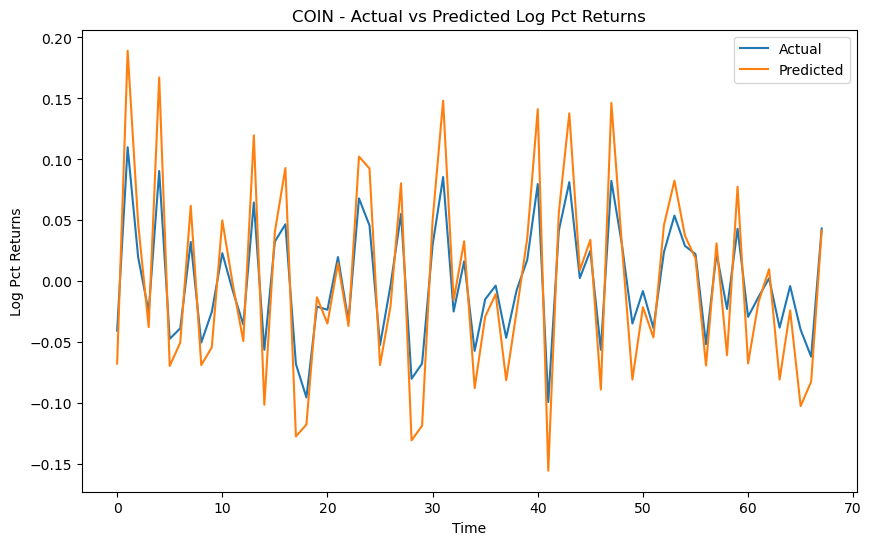

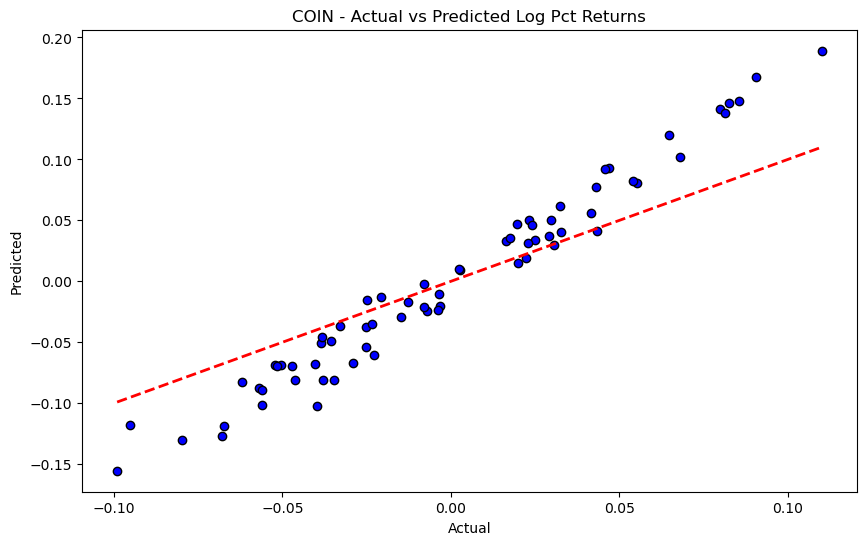

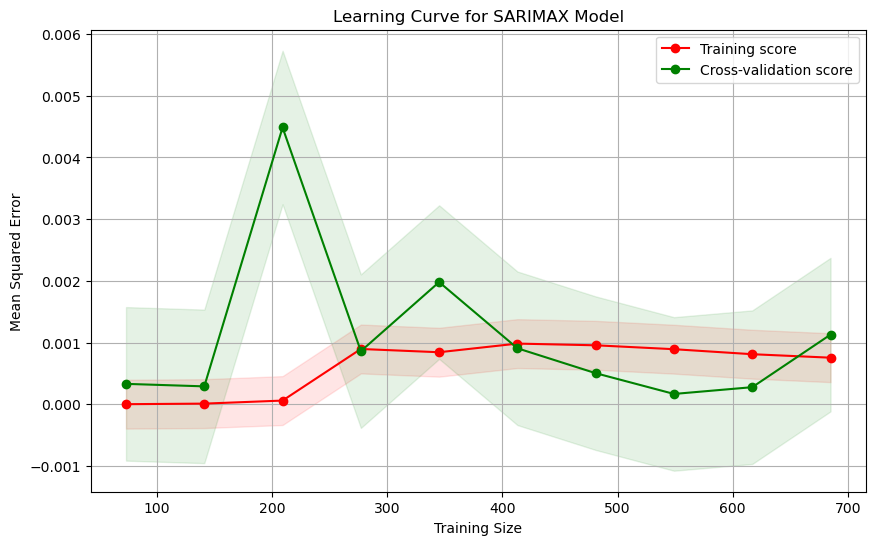

Future predictions saved to coin_usd_future_predictions.csv


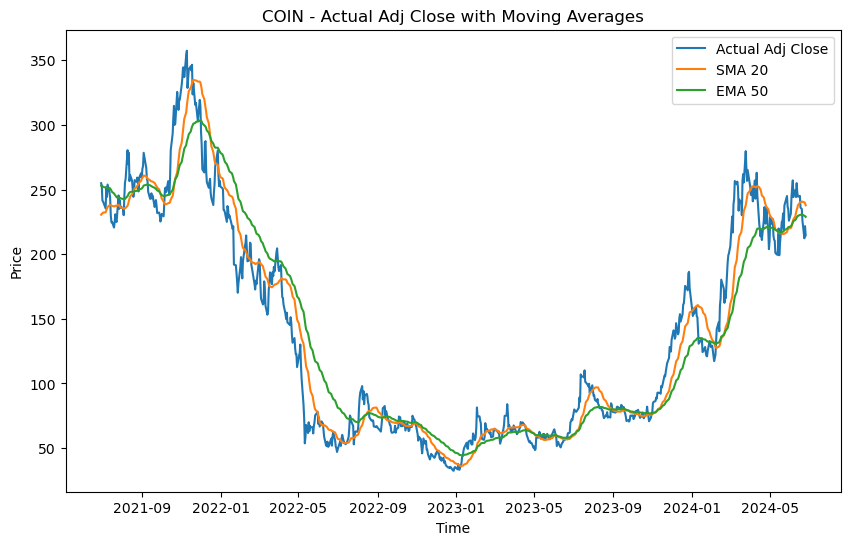

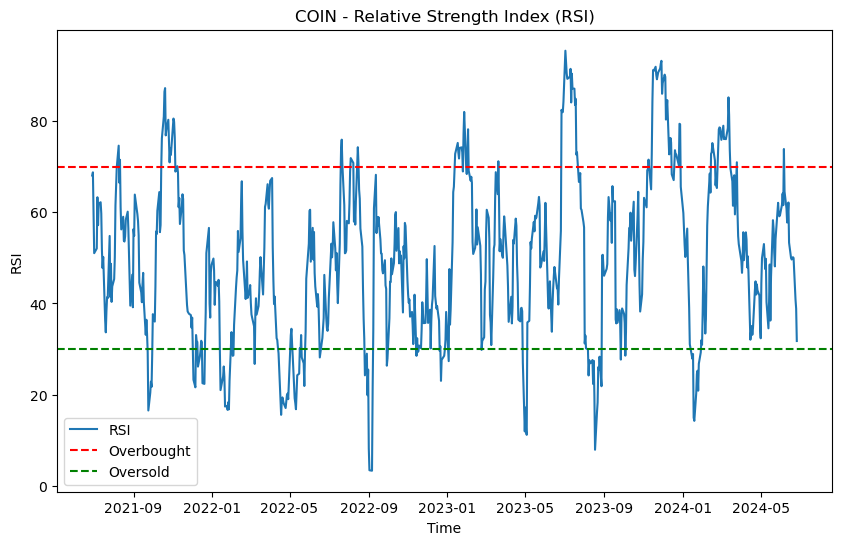

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

def download_data(ticker, start_date, end_date):
    data = yf.download(tickers=ticker, start=start_date, end=end_date)
    df = pd.DataFrame(data)
    df.reset_index(inplace=True)
    df.set_index('Date', inplace=True)
    return df

def add_features(df, df_gold, df_usindex):
    df['Gold_Adj_Close'] = df_gold['Adj Close']
    df['USIndex_Adj_Close'] = df_usindex['Adj Close']
    df.ffill(inplace=True)

    # Calculate additional features
    df['Open_Close_Diff'] = df['Open'] - df['Adj Close']
    df['High_Low_Diff'] = df['High'] - df['Low']
    df['Pct_Returns'] = df['Adj Close'].pct_change()
    df['Log_Pct_Returns'] = np.log(1 + df['Pct_Returns'])
    df.dropna(inplace=True)

    # Moving Averages
    df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
    df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
    df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

    # Relative Strength Index (RSI)
    window_length = 14
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    loss = (-delta.where(delta<0, 0)).rolling(window=window_length).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD)
    df['MACD'] = df['Adj Close'].ewm(span=12, adjust=False).mean() - df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # Bollinger Bands
    df['BB_Upper'] = df['SMA_20'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_Lower'] = df['SMA_20'] - 2 * df['Adj Close'].rolling(window=20).std()

    # Stochastic Oscillator
    df['14-high'] = df['High'].rolling(14).max()
    df['14-low'] = df['Low'].rolling(14).min()
    df['%K'] = (df['Adj Close'] - df['14-low']) * 100 / (df['14-high'] - df['14-low'])
    df['%D'] = df['%K'].rolling(3).mean()

    # Average True Range (ATR)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = np.abs(df['High'] - df['Adj Close'].shift(1))
    df['L-PC'] = np.abs(df['Low'] - df['Adj Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(14).mean()

    return df

def shift_columns(df, columns_to_shift, num_lags):
    for column in columns_to_shift:
        for lag in range(1, num_lags + 1):
            df[f'{column}_{lag}'] = df[column].shift(lag)
    df['Pct_Returns_1'] = df['Pct_Returns'].shift(1)
    df['Log_Pct_Returns_1'] = df['Log_Pct_Returns'].shift(1)
    df.dropna(inplace=True)
    return df

def fetch_and_preprocess_economic_data(start_date, end_date):
    economic_indicators = {
        'T5YIE': 'Inflation',
        'FEDFUNDS': 'FedFunds',
        'GDPC1': 'GDP',
        'UNRATE': 'Unemployment',
        'UMCSENT': 'ConsumerSentiment',
        'CPILFESL': 'CoreCPI',
        'PPIACO': 'CommodityPrices',
        'WM2NS': 'M2MoneySupply'
    }
    
    dfs_economic = {}
    
    for code, name in economic_indicators.items():
        df = pdr.get_data_fred(code, start=start_date, end=end_date)
        df = df.resample('D').ffill().dropna()
        df.columns = [name]
        dfs_economic[name] = df
    
    return dfs_economic

def merge_economic_data(df, dfs_economic):
    for econ_name, econ_df in dfs_economic.items():
        df[econ_name] = econ_df[econ_name]
    return df

def evaluate_model(y_train, y_test, y_train_pred, y_test_pred):
    metrics = {}
    metrics['train_mse'] = mean_squared_error(y_train, y_train_pred)
    metrics['test_mse'] = mean_squared_error(y_test, y_test_pred)
    metrics['train_rmse'] = np.sqrt(metrics['train_mse'])
    metrics['test_rmse'] = np.sqrt(metrics['test_mse'])
    metrics['train_mae'] = mean_absolute_error(y_train, y_train_pred)
    metrics['test_mae'] = mean_absolute_error(y_test, y_test_pred)
    metrics['train_r2'] = r2_score(y_train, y_train_pred)
    metrics['test_r2'] = r2_score(y_test, y_test_pred)
    return metrics

def plot_results(y_test, y_test_pred):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_test_pred.values, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Log Pct Returns')
    plt.title('COIN - Actual vs Predicted Log Pct Returns')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('COIN - Actual vs Predicted Log Pct Returns')
    plt.show()

def future_prediction(model_fit, future_steps, X_scaled):
    future_dates = pd.date_range(start=df_coin.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='B')
    future_exog = X_scaled[-future_steps:]
    future_predictions = model_fit.get_forecast(steps=future_steps, exog=future_exog).predicted_mean
    df_future_predictions = pd.DataFrame({'Date': future_dates, 'Predicted_Log_Return': future_predictions})
    df_future_predictions.set_index('Date', inplace=True)
    return df_future_predictions

def plot_learning_curve(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std):
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve for SARIMAX Model')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Download data
df_coin = download_data('COIN', start_date, end_date)
df_gold = download_data('GC=F', start_date, end_date)
df_usindex = download_data('DX-Y.NYB', start_date, end_date)

# Add features
df_coin = add_features(df_coin, df_gold, df_usindex)

# Shift columns to create lagged features
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
    'Open_Close_Diff', 'High_Low_Diff',
    'Gold_Adj_Close', 'USIndex_Adj_Close',
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50',
    'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Lower',
    '%K', '%D', 'ATR'
]
num_lags = 3
df_coin = shift_columns(df_coin, columns_to_shift, num_lags)

# Fetch and merge economic data
dfs_economic = fetch_and_preprocess_economic_data(start_date, end_date)
df_coin = merge_economic_data(df_coin, dfs_economic)

# Define features and target variable
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'USIndex_Adj_Close_1',
            'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','USIndex_Adj_Close_2',
            'Open_3',  'Low_3',
            'USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1',
            'EMA_50_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1',  '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_50_2',
            'MACD_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
           ]
X = df_coin[features].dropna()
y = df_coin['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Hyperparameter tuning
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

best_r2 = float('-inf')
best_params = None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            r2_scores = []
            for train_index, test_index in tscv.split(X_scaled):
                X_train, X_test = X_scaled[train_index], X_scaled[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = SARIMAX(y_train, exog=X_train, order=param, seasonal_order=param_seasonal)
                model_fit = model.fit(disp=False)
                y_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)
                r2 = r2_score(y_test, y_pred)
                r2_scores.append(r2)

            avg_r2 = np.mean(r2_scores)
            print(f"Testing {param} x {param_seasonal} - R2: {avg_r2}")  # Debug output
            if avg_r2 > best_r2:
                best_r2 = avg_r2
                best_params = (param, param_seasonal)
        except Exception as e:
            print(f"Failed to fit model with parameters {param} x {param_seasonal}: {e}")  # Error feedback

print(f'Best SARIMAX configuration: {best_params} with R2: {best_r2}')

# Perform cross-validation with the best SARIMAX configuration
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []

train_sizes, train_scores, test_scores = [], [], []

for train_index, test_index in tscv.split(X_scaled):
    train_sizes.append(len(train_index))
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit SARIMAX model with the best parameters
    model = SARIMAX(y_train, exog=X_train, order=best_params[0], seasonal_order=best_params[1])
    model_fit = model.fit(disp=False)

    # Predict on the test set
    y_train_pred = model_fit.predict(start=train_index[0], end=train_index[-1], exog=X_train)
    y_test_pred = model_fit.predict(start=test_index[0], end=test_index[-1], exog=X_test)

    # Evaluate model
    metrics = evaluate_model(y_train, y_test, y_train_pred, y_test_pred)

    # Append metrics to lists
    train_mse_scores.append(metrics['train_mse'])
    test_mse_scores.append(metrics['test_mse'])
    train_rmse_scores.append(metrics['train_rmse'])
    test_rmse_scores.append(metrics['test_rmse'])
    train_mae_scores.append(metrics['train_mae'])
    test_mae_scores.append(metrics['test_mae'])
    train_r2_scores.append(metrics['train_r2'])
    test_r2_scores.append(metrics['test_r2'])

    train_scores.append(metrics['train_mse'])
    test_scores.append(metrics['test_mse'])

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Print Results
print("COIN - Training MSE: {:.4f}".format(mean_train_mse))
print("COIN - Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("COIN - Test MSE: {:.4f}".format(mean_test_mse))
print("COIN - Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("COIN - Training RMSE: {:.4f}".format(mean_train_rmse))
print("COIN - Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("COIN - Test RMSE: {:.4f}".format(mean_test_rmse))
print("COIN - Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("COIN - Training MAE: {:.4f}".format(mean_train_mae))
print("COIN - Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("COIN - Test MAE: {:.4f}".format(mean_test_mae))
print("COIN - Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("COIN - Training R2: {:.4f}".format(mean_train_r2))
print("COIN - Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("COIN - Test R2: {:.4f}".format(mean_test_r2))
print("COIN - Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize model performance
plot_results(y_test, y_test_pred)

# Learning curve
plot_learning_curve(np.array(train_sizes), np.array(train_scores), np.std(train_scores), np.array(test_scores), np.std(test_scores))

# Future prediction for 365 days
future_steps = 365
df_future_predictions = future_prediction(model_fit, future_steps, X_scaled)

# Save results to CSV
df_future_predictions.to_csv('coin_usd_future_predictions.csv')
print("Future predictions saved to coin_usd_future_predictions.csv")

# Additional Plots
plt.figure(figsize=(10, 6))
plt.plot(df_coin['Adj Close'], label='Actual Adj Close')
plt.plot(df_coin['SMA_20'], label='SMA 20')
plt.plot(df_coin['EMA_50'], label='EMA 50')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('COIN - Actual Adj Close with Moving Averages')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(df_coin['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.title('COIN - Relative Strength Index (RSI)')
plt.legend()
plt.show()


In [4]:
def calculate_variance_from_std(std_dev):
    """
    Calculate variance from standard deviation.

    :param std_dev: The standard deviation value.
    :return: The variance.
    """
    return std_dev ** 2

def print_metrics_with_variance(mean_std_dev_pairs):
    """
    Print mean, standard deviation, and variance for given metrics.

    :param mean_std_dev_pairs: A list of tuples containing metric names and their mean and std_dev values.
    """
    for metric_name, mean_value, std_dev_value in mean_std_dev_pairs:
        variance_value = calculate_variance_from_std(std_dev_value)
        print(f"{metric_name} - Mean: {mean_value:.4f}, Std Dev: {std_dev_value:.4f}, Variance: {variance_value:.6f}")

# Example usage with your variables
mean_std_dev_pairs = [
    ("Training MSE", mean_train_mse, std_train_mse),
    ("Test MSE", mean_test_mse, std_test_mse),
    ("Training RMSE", mean_train_rmse, std_train_rmse),
    ("Test RMSE", mean_test_rmse, std_test_rmse),
    ("Training MAE", mean_train_mae, std_train_mae),
    ("Test MAE", mean_test_mae, std_test_mae),
    ("Training R2", mean_train_r2, std_train_r2),
    ("Test R2", mean_test_r2, std_test_r2)
]

print_metrics_with_variance(mean_std_dev_pairs)


Training MSE - Mean: 0.0006, Std Dev: 0.0004, Variance: 0.000000
Test MSE - Mean: 0.0011, Std Dev: 0.0012, Variance: 0.000002
Training RMSE - Mean: 0.0219, Std Dev: 0.0118, Variance: 0.000140
Test RMSE - Mean: 0.0292, Std Dev: 0.0156, Variance: 0.000242
Training MAE - Mean: 0.0156, Std Dev: 0.0083, Variance: 0.000070
Test MAE - Mean: 0.0227, Std Dev: 0.0126, Variance: 0.000158
Training R2 - Mean: 0.8243, Std Dev: 0.1059, Variance: 0.011216
Test R2 - Mean: 0.7376, Std Dev: 0.1371, Variance: 0.018791
